In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
data = pd.read_csv('services.csv')
data.head()

,branch_id,date,queue_id,sequence,status,entity,priority,arrival_time,start_time,end_time,client_id,cashier,service_type,waiting_time
0,5,01/08/2016,73,65,finished,person,False,11:17:23,12:15:04,12:22:44,NaN,109,D,00:57:41
1,5,01/08/2016,73,224,finished,company,False,13:10:57,14:16:46,14:17:54,NaN,109,D,01:05:49
2,6,01/08/2016,34,259,finished,person,False,13:36:52,13:48:33,13:51:33,NaN,3,D,00:11:41
3,25,01/08/2016,6,40,finished,person,False,10:58:16,11:25:34,11:25:44,NaN,11,E,00:27:18
4,25,01/08/2016,6,67,finished,person,False,11:54:41,12:34:12,12:34:51,3184.0,11,E,00:39:31


In [ ]:
data = data.sort_values(by = ['date','arrival_time'])
data.head()

,branch_id,date,queue_id,sequence,status,entity,priority,arrival_time,start_time,end_time,client_id,cashier,service_type,waiting_time
182,43,01/08/2016,5,1,finished,person,False,09:59:13,10:00:52,10:06:01,NaN,73,C,00:01:39
183,43,01/08/2016,5,2,finished,person,False,09:59:28,10:06:03,10:11:56,NaN,73,C,00:06:35
97,30,01/08/2016,3,1,finished,person,True,09:59:56,10:05:14,10:08:43,11151.0,144,A,00:05:18
6,30,01/08/2016,2,2,finished,person,False,10:00:14,10:17:13,10:18:42,12449.0,144,C,00:16:59
242,45,01/08/2016,2,3,finished,person,True,10:01:30,10:02:21,10:06:31,8257.0,92,A,00:00:51


In [ ]:
# Convert arrival time, waiting time, and service time to minutes
data['arrival_time'] = pd.to_datetime(data['arrival_time'], format='%H:%M:%S').dt.hour * 60 + pd.to_datetime(data['arrival_time'], format='%H:%M:%S').dt.minute
data['start_time'] = pd.to_datetime(data['start_time'], format='%H:%M:%S').dt.hour * 60 + pd.to_datetime(data['start_time'], format='%H:%M:%S').dt.minute
data['end_time'] = pd.to_datetime(data['end_time'], format='%H:%M:%S').dt.hour * 60 + pd.to_datetime(data['end_time'], format='%H:%M:%S').dt.minute
data['waiting_time'] = pd.to_datetime(data['waiting_time'], format='%H:%M:%S').dt.hour * 60 + pd.to_datetime(data['waiting_time'], format='%H:%M:%S').dt.minute
data['date'] = pd.to_datetime(data['date'])
data['date'] = data['date'].astype(int)

<ipython-input-4-96639ecc684a>:6: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data['date'] = pd.to_datetime(data['date'])


In [ ]:
encoder = LabelEncoder()
data['priority'] = encoder.fit_transform(data['priority'])
data['entity'] = encoder.fit_transform(data['entity'])
data['service_type'] = encoder.fit_transform(data['service_type'])
data['status'] = encoder.fit_transform(data['status'])
data.head()

,branch_id,date,queue_id,sequence,status,entity,priority,arrival_time,start_time,end_time,client_id,cashier,service_type,waiting_time
182,43,1452211200000000000,5,1,0,1,0,599,600,606,NaN,73,1,1
183,43,1452211200000000000,5,2,0,1,0,599,606,611,NaN,73,1,6
97,30,1452211200000000000,3,1,0,1,1,599,605,608,11151.0,144,0,5
6,30,1452211200000000000,2,2,0,1,0,600,617,618,12449.0,144,1,16
242,45,1452211200000000000,2,3,0,1,1,601,602,606,8257.0,92,0,0


In [ ]:
# Define a custom function to calculate queue length
def calculate_queue_length(row, data):
    return data[(data['date'] == row['date']) &
        (data['queue_id'] == row['queue_id']) &
        (data['branch_id'] == row['branch_id']) &
        (data['arrival_time'] < row['start_time'])]['arrival_time'].count()

# Apply the custom function to each row
data['queue_length'] = data.apply(calculate_queue_length, axis=1, data=data)
data.head()

,branch_id,date,queue_id,sequence,status,entity,priority,arrival_time,start_time,end_time,client_id,cashier,service_type,waiting_time,queue_length
182,43,1452211200000000000,5,1,0,1,0,599,600,606,NaN,73,1,1,2
183,43,1452211200000000000,5,2,0,1,0,599,606,611,NaN,73,1,6,3
97,30,1452211200000000000,3,1,0,1,1,599,605,608,11151.0,144,0,5,2
6,30,1452211200000000000,2,2,0,1,0,600,617,618,12449.0,144,1,16,11
242,45,1452211200000000000,2,3,0,1,1,601,602,606,8257.0,92,0,0,2


In [ ]:
features_to_scale = ['branch_id','date','queue_id','sequence','status','entity','priority','arrival_time','start_time','end_time','cashier','service_type','waiting_time','queue_length']
scalar = StandardScaler()
data = data[['branch_id','date','queue_id','sequence','status','entity','priority','arrival_time','start_time','end_time','cashier','service_type','waiting_time','queue_length']]
data_s = pd.DataFrame(scalar.fit_transform(data), columns=features_to_scale) #scaling the data
data_s.head()

,branch_id,date,queue_id,sequence,status,entity,priority,arrival_time,start_time,end_time,cashier,service_type,waiting_time,queue_length
0,0.510836,-2.587635,0.351750,-1.347179,-0.352708,0.321876,-0.551410,-1.477670,-1.608023,-1.545675,-0.528034,0.301529,-0.560150,-1.164439
1,0.510836,-2.587635,0.351750,-1.325201,-0.352708,0.321876,-0.551410,-1.477670,-1.547591,-1.496098,-0.528034,0.301529,-0.361022,-1.118455
2,-0.367590,-2.587635,-0.132649,-1.347179,-0.352708,0.321876,1.813531,-1.477670,-1.557663,-1.525844,1.092128,-1.407585,-0.400847,-1.164439
3,-0.367590,-2.587635,-0.374849,-1.325201,-0.352708,0.321876,-0.551410,-1.467487,-1.436798,-1.426689,1.092128,0.301529,0.037234,-0.750584
4,0.645978,-2.587635,-0.374849,-1.303223,-0.352708,0.321876,1.813531,-1.457304,-1.587879,-1.545675,-0.094469,-1.407585,-0.599975,-1.164439


In [ ]:
# Assuming 'waiting_time' is the target variable
X = data_s.drop(['waiting_time','start_time','end_time'], axis=1)
y = data['waiting_time']

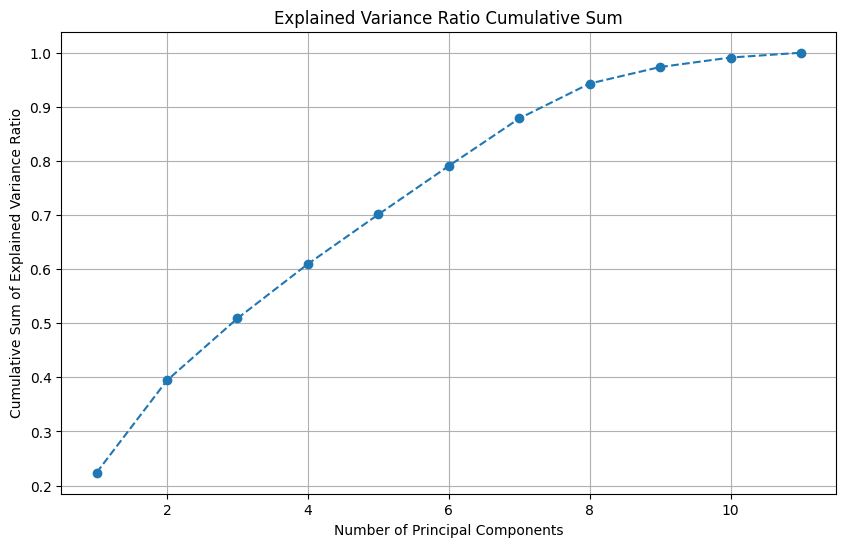

In [ ]:
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=11)  # You can adjust the explained variance threshold as needed
X_pca = pca.fit_transform(X)

# Create a DataFrame with the reduced feature set
columns_pca = [f'PC{i}' for i in range(1, X_pca.shape[1] + 1)]
x_pca = pd.DataFrame(data=X_pca, columns=columns_pca)

# Display the DataFrame with the reduced feature set
x_pca.head()

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio.cumsum(), marker='o', linestyle='--')
plt.title('Explained Variance Ratio Cumulative Sum')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Sum of Explained Variance Ratio')
plt.grid(True)
plt.show()

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_pca, y, test_size=0.2, random_state=42)

# Create a Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

In [ ]:
et_model = ExtraTreesRegressor(n_estimators = 100, random_state=42)

In [ ]:
# Initialize selected features list and r2 scores list
selected_features_step1 = []
r2_scores_step1 = []

# Step 1: Fit the model with one predictor and target
for feature in x_pca.columns:
    X_train_selected = X_train[[feature]]
    X_test_selected = X_test[[feature]]
    #rf_model.fit(X_train_selected, y_train)
    #y_pred = rf_model.predict(X_test_selected)
    et_model.fit(X_train_selected, y_train)
    y_pred = et_model.predict(X_test_selected)
    r2 = r2_score(y_test, y_pred)
    selected_features_step1.append(feature)
    r2_scores_step1.append(r2)

step1_df = pd.DataFrame({'Selected Features': selected_features_step1, 'R2 Score': r2_scores_step1})
print(step1_df)
step1_df.to_excel("PCA_step1.xlsx")

   Selected Features  R2 Score
0                PC1 -0.576091
1                PC2 -0.505194
2                PC3 -0.085064
3                PC4 -0.207418
4                PC5 -0.496374
5                PC6 -0.238063
6                PC7 -0.389550
7                PC8 -0.362040
8                PC9  0.089891
9               PC10 -0.496747
10              PC11 -0.467299


In [ ]:
# Select the feature with the highest absolute magnitude of R-squared score
best_feature_index = r2_scores_step1.index(max(r2_scores_step1))
best_feature = selected_features_step1[best_feature_index]

# Step 2: Fit the model with the selected feature and one from the remaining predictors
selected_features_step2 = []
r2_scores_step2 = []
for feature2 in x_pca.columns:
    if feature2 != best_feature:
        combined_features = [best_feature, feature2]
        X_train_combined = X_train[combined_features]
        X_test_combined = X_test[combined_features]
        #rf_model.fit(X_train_combined, y_train)
        #y_pred = rf_model.predict(X_test_combined)
        et_model.fit(X_train_combined, y_train)
        y_pred = et_model.predict(X_test_combined)
        r2 = r2_score(y_test, y_pred)
        selected_features_step2.append(combined_features)
        r2_scores_step2.append(r2)

step2_df = pd.DataFrame({'Selected Features': selected_features_step2, 'R2 Score': r2_scores_step2})
print(step2_df)
step2_df.to_excel("PCA_step2.xlsx")

  Selected Features  R2 Score
0        [PC9, PC1]  0.448314
1        [PC9, PC2]  0.444884
2        [PC9, PC3]  0.680953
3        [PC9, PC4]  0.485043
4        [PC9, PC5]  0.522666
5        [PC9, PC6]  0.581106
6        [PC9, PC7]  0.599335
7        [PC9, PC8]  0.605016
8       [PC9, PC10]  0.415569
9       [PC9, PC11]  0.408133


In [ ]:
# Select the features with the highest R-squared score from Step 2
best_feature_index_step2 = r2_scores_step2.index(max(r2_scores_step2))
best_feature_step2 = selected_features_step2[best_feature_index_step2]

# Step 3: Fit the model with the selected features from Step 2 and one from the remaining predictors
selected_features_step3 = []
r2_scores_step3 = []

for feature3 in x_pca.columns:
    if feature3 not in best_feature_step2:
        combined_features = best_feature_step2 + [feature3]
        X_train_combined = X_train[combined_features]
        X_test_combined = X_test[combined_features]
        #rf_model.fit(X_train_combined, y_train)
        #y_pred = rf_model.predict(X_test_combined)
        et_model.fit(X_train_combined, y_train)
        y_pred = et_model.predict(X_test_combined)
        r2 = r2_score(y_test, y_pred)
        selected_features_step3.append(combined_features)
        r2_scores_step3.append(r2)

step3_df = pd.DataFrame({'Selected Features': selected_features_step3, 'R2 Score': r2_scores_step3})
print(step3_df)
step3_df.to_excel("PCA_step3.xlsx")

  Selected Features  R2 Score
0   [PC9, PC3, PC1]  0.795300
1   [PC9, PC3, PC2]  0.813700
2   [PC9, PC3, PC4]  0.817378
3   [PC9, PC3, PC5]  0.830140
4   [PC9, PC3, PC6]  0.844856
5   [PC9, PC3, PC7]  0.848923
6   [PC9, PC3, PC8]  0.852349
7  [PC9, PC3, PC10]  0.803774
8  [PC9, PC3, PC11]  0.785924


In [ ]:
# Select the features with the highest R-squared score from Step 3
best_feature_index_step3 = r2_scores_step3.index(max(r2_scores_step3))
best_feature_step3 = selected_features_step3[best_feature_index_step3]

# Step 4: Fit the model with the selected features from Step 3 and one from the remaining predictors
selected_features_step4 = []
r2_scores_step4 = []

for feature4 in x_pca.columns:
    if feature4 not in best_feature_step3:
        combined_features = best_feature_step3 + [feature4]
        X_train_combined = X_train[combined_features]
        X_test_combined = X_test[combined_features]
        #rf_model.fit(X_train_combined, y_train)
        #y_pred = rf_model.predict(X_test_combined)
        et_model.fit(X_train_combined, y_train)
        y_pred = et_model.predict(X_test_combined)
        r2 = r2_score(y_test, y_pred)
        selected_features_step4.append(combined_features)
        r2_scores_step4.append(r2)

step4_df = pd.DataFrame({'Selected Features': selected_features_step4, 'R2 Score': r2_scores_step4})
print(step4_df)
step4_df.to_excel("PCA_step4.xlsx")

       Selected Features  R2 Score
0   [PC9, PC3, PC8, PC1]  0.874610
1   [PC9, PC3, PC8, PC2]  0.880485
2   [PC9, PC3, PC8, PC4]  0.882333
3   [PC9, PC3, PC8, PC5]  0.882733
4   [PC9, PC3, PC8, PC6]  0.883996
5   [PC9, PC3, PC8, PC7]  0.879280
6  [PC9, PC3, PC8, PC10]  0.880725
7  [PC9, PC3, PC8, PC11]  0.878450


In [ ]:
# Select the features with the highest R-squared score from Step 4
best_feature_index_step4 = r2_scores_step4.index(max(r2_scores_step4))
best_feature_step4 = selected_features_step4[best_feature_index_step4]

# Step 5: Fit the model with the selected features from Step 4 and one from the remaining predictors
selected_features_step5 = []
r2_scores_step5 = []

for feature5 in x_pca.columns:
    if feature5 not in best_feature_step4:
        combined_features = best_feature_step4 + [feature5]
        X_train_combined = X_train[combined_features]
        X_test_combined = X_test[combined_features]
        #rf_model.fit(X_train_combined, y_train)
        #y_pred = rf_model.predict(X_test_combined)
        et_model.fit(X_train_combined, y_train)
        y_pred = et_model.predict(X_test_combined)
        r2 = r2_score(y_test, y_pred)
        selected_features_step5.append(combined_features)
        r2_scores_step5.append(r2)

step5_df = pd.DataFrame({'Selected Features': selected_features_step5, 'R2 Score': r2_scores_step5})
print(step5_df)
step4_df.to_excel("PCA_step4.xlsx")

            Selected Features  R2 Score
0   [PC9, PC3, PC8, PC6, PC1]  0.894820
1   [PC9, PC3, PC8, PC6, PC2]  0.898645
2   [PC9, PC3, PC8, PC6, PC4]  0.903994
3   [PC9, PC3, PC8, PC6, PC5]  0.897279
4   [PC9, PC3, PC8, PC6, PC7]  0.895868
5  [PC9, PC3, PC8, PC6, PC10]  0.898162
6  [PC9, PC3, PC8, PC6, PC11]  0.892318


In [ ]:
# Select the features with the highest R-squared score from Step 5
best_feature_index_step5 = r2_scores_step5.index(max(r2_scores_step5))
best_feature_step5 = selected_features_step5[best_feature_index_step5]

# Step 6: Fit the model with the selected features from Step 5 and one from the remaining predictors
selected_features_step6 = []
r2_scores_step6 = []

for feature6 in x_pca.columns:
    if feature6 not in best_feature_step5:
        combined_features = best_feature_step5 + [feature6]
        X_train_combined = X_train[combined_features]
        X_test_combined = X_test[combined_features]
        #rf_model.fit(X_train_combined, y_train)
        #y_pred = rf_model.predict(X_test_combined)
        et_model.fit(X_train_combined, y_train)
        y_pred = et_model.predict(X_test_combined)
        r2 = r2_score(y_test, y_pred)
        selected_features_step6.append(combined_features)
        r2_scores_step6.append(r2)

step6_df = pd.DataFrame({'Selected Features': selected_features_step6, 'R2 Score': r2_scores_step6})
print(step6_df)
step5_df.to_excel("PCA_step5.xlsx")

                 Selected Features  R2 Score
0   [PC9, PC3, PC8, PC6, PC4, PC1]  0.903525
1   [PC9, PC3, PC8, PC6, PC4, PC2]  0.908951
2   [PC9, PC3, PC8, PC6, PC4, PC5]  0.907818
3   [PC9, PC3, PC8, PC6, PC4, PC7]  0.907162
4  [PC9, PC3, PC8, PC6, PC4, PC10]  0.909335
5  [PC9, PC3, PC8, PC6, PC4, PC11]  0.904689


In [ ]:
# Select the features with the highest R-squared score from Step 6
best_feature_index_step6 = r2_scores_step6.index(max(r2_scores_step6))
best_feature_step6 = selected_features_step6[best_feature_index_step6]

# Step 7: Fit the model with the selected features from Step 6 and one from the remaining predictors
selected_features_step7 = []
r2_scores_step7 = []

for feature7 in x_pca.columns:
    if feature7 not in best_feature_step6:
        combined_features = best_feature_step6 + [feature7]
        X_train_combined = X_train[combined_features]
        X_test_combined = X_test[combined_features]
        #rf_model.fit(X_train_combined, y_train)
        #y_pred = rf_model.predict(X_test_combined)
        et_model.fit(X_train_combined, y_train)
        y_pred = et_model.predict(X_test_combined)
        r2 = r2_score(y_test, y_pred)
        selected_features_step7.append(combined_features)
        r2_scores_step7.append(r2)

step7_df = pd.DataFrame({'Selected Features': selected_features_step7, 'R2 Score': r2_scores_step7})
print(step7_df)
step6_df.to_excel("PCA_step6.xlsx")

                       Selected Features  R2 Score
0   [PC9, PC3, PC8, PC6, PC4, PC10, PC1]  0.906478
1   [PC9, PC3, PC8, PC6, PC4, PC10, PC2]  0.911815
2   [PC9, PC3, PC8, PC6, PC4, PC10, PC5]  0.911053
3   [PC9, PC3, PC8, PC6, PC4, PC10, PC7]  0.911948
4  [PC9, PC3, PC8, PC6, PC4, PC10, PC11]  0.910758


In [ ]:
# Select the features with the highest R-squared score from Step 7
best_feature_index_step7 = r2_scores_step7.index(max(r2_scores_step7))
best_feature_step7 = selected_features_step7[best_feature_index_step7]

# Step 8: Fit the model with the selected features from Step 7 and one from the remaining predictors
selected_features_step8 = []
r2_scores_step8 = []

for feature8 in x_pca.columns:
    if feature8 not in best_feature_step7:
        combined_features = best_feature_step7 + [feature8]
        X_train_combined = X_train[combined_features]
        X_test_combined = X_test[combined_features]
        #rf_model.fit(X_train_combined, y_train)
        #y_pred = rf_model.predict(X_test_combined)
        et_model.fit(X_train_combined, y_train)
        y_pred = et_model.predict(X_test_combined)
        r2 = r2_score(y_test, y_pred)
        selected_features_step8.append(combined_features)
        r2_scores_step8.append(r2)

step8_df = pd.DataFrame({'Selected Features': selected_features_step8, 'R2 Score': r2_scores_step8})
print(step8_df)
step7_df.to_excel("PCA_step7.xlsx")

                            Selected Features  R2 Score
0   [PC9, PC3, PC8, PC6, PC4, PC10, PC7, PC1]  0.912256
1   [PC9, PC3, PC8, PC6, PC4, PC10, PC7, PC2]  0.911755
2   [PC9, PC3, PC8, PC6, PC4, PC10, PC7, PC5]  0.914015
3  [PC9, PC3, PC8, PC6, PC4, PC10, PC7, PC11]  0.912504


In [ ]:
# Select the features with the highest R-squared score from Step 7
best_feature_index_step7 = r2_scores_step7.index(max(r2_scores_step7))
best_feature_step7 = selected_features_step7[best_feature_index_step7]

# Step 8: Fit the model with the selected features from Step 7 and one from the remaining PCA-transformed features
selected_features_step8 = []
r2_scores_step8 = []

for feature8 in x_pca.columns:
    if feature8 not in best_feature_step7:
        combined_features = best_feature_step7 + [feature8]
        X_train_combined = X_train[combined_features]
        X_test_combined = X_test[combined_features]
        #rf_model.fit(X_train_combined, y_train)
        #y_pred = rf_model.predict(X_test_combined)
        et_model.fit(X_train_combined, y_train)
        y_pred = et_model.predict(X_test_combined)
        r2 = r2_score(y_test, y_pred)
        selected_features_step8.append(combined_features)
        r2_scores_step8.append(r2)

step8_df = pd.DataFrame({'Selected Features': selected_features_step8, 'R2 Score': r2_scores_step8})
print(step8_df)
step8_df.to_excel("PCA_step8.xlsx")


                            Selected Features  R2 Score
0   [PC9, PC3, PC8, PC6, PC4, PC10, PC7, PC1]  0.912256
1   [PC9, PC3, PC8, PC6, PC4, PC10, PC7, PC2]  0.911755
2   [PC9, PC3, PC8, PC6, PC4, PC10, PC7, PC5]  0.914015
3  [PC9, PC3, PC8, PC6, PC4, PC10, PC7, PC11]  0.912504


In [ ]:
# Select the features with the highest R-squared score from Step 8
best_feature_index_step8 = r2_scores_step8.index(max(r2_scores_step8))
best_feature_step8 = selected_features_step8[best_feature_index_step8]

# Step 9: Fit the model with the selected features from Step 8 and one from the remaining PCA-transformed features
selected_features_step9 = []
r2_scores_step9 = []

for feature9 in x_pca.columns:
    if feature9 not in best_feature_step8:
        combined_features = best_feature_step8 + [feature9]
        X_train_combined = X_train[combined_features]
        X_test_combined = X_test[combined_features]
        #rf_model.fit(X_train_combined, y_train)
        #y_pred = rf_model.predict(X_test_combined)
        et_model.fit(X_train_combined, y_train)
        y_pred = et_model.predict(X_test_combined)
        r2 = r2_score(y_test, y_pred)
        selected_features_step9.append(combined_features)
        r2_scores_step9.append(r2)

step9_df = pd.DataFrame({'Selected Features': selected_features_step9, 'R2 Score': r2_scores_step9})
print(step9_df)
step9_df.to_excel("PCA_step9.xlsx")


                                 Selected Features  R2 Score
0   [PC9, PC3, PC8, PC6, PC4, PC10, PC7, PC5, PC1]  0.913392
1   [PC9, PC3, PC8, PC6, PC4, PC10, PC7, PC5, PC2]  0.914050
2  [PC9, PC3, PC8, PC6, PC4, PC10, PC7, PC5, PC11]  0.914899


In [ ]:
# Select the features with the highest R-squared score from Step 9
best_feature_index_step9 = r2_scores_step9.index(max(r2_scores_step9))
best_feature_step9 = selected_features_step9[best_feature_index_step9]

# Step 10: Fit the model with the selected features from Step 9 and one from the remaining PCA-transformed features
selected_features_step10 = []
r2_scores_step10 = []

for feature10 in x_pca.columns:
    if feature10 not in best_feature_step9:
        combined_features = best_feature_step9 + [feature10]
        X_train_combined = X_train[combined_features]
        X_test_combined = X_test[combined_features]
        #rf_model.fit(X_train_combined, y_train)
        #y_pred = rf_model.predict(X_test_combined)
        et_model.fit(X_train_combined, y_train)
        y_pred = et_model.predict(X_test_combined)
        r2 = r2_score(y_test, y_pred)
        selected_features_step10.append(combined_features)
        r2_scores_step10.append(r2)

step10_df = pd.DataFrame({'Selected Features': selected_features_step10, 'R2 Score': r2_scores_step10})
print(step10_df)
step10_df.to_excel("PCA_step10.xlsx")

                                   Selected Features  R2 Score
0  [PC9, PC3, PC8, PC6, PC4, PC10, PC7, PC5, PC11...  0.913496
1  [PC9, PC3, PC8, PC6, PC4, PC10, PC7, PC5, PC11...  0.912482


In [ ]:
# Select the features with the highest R-squared score from Step 10
best_feature_index_step10 = r2_scores_step10.index(max(r2_scores_step10))
best_feature_step10 = selected_features_step10[best_feature_index_step10]

# Step 11: Fit the model with the selected features from Step 10 and one from the remaining PCA-transformed features
selected_features_step11 = []
r2_scores_step11 = []

for feature11 in x_pca.columns:
    if feature11 not in best_feature_step10:
        combined_features = best_feature_step10 + [feature11]
        X_train_combined = X_train[combined_features]
        X_test_combined = X_test[combined_features]
        #rf_model.fit(X_train_combined, y_train)
        #y_pred = rf_model.predict(X_test_combined)
        et_model.fit(X_train_combined, y_train)
        y_pred = et_model.predict(X_test_combined)
        r2 = r2_score(y_test, y_pred)
        selected_features_step11.append(combined_features)
        r2_scores_step11.append(r2)

step11_df = pd.DataFrame({'Selected Features': selected_features_step11, 'R2 Score': r2_scores_step11})
print(step11_df)
step11_df.to_excel("PCA_step11.xlsx")


                                   Selected Features  R2 Score
0  [PC9, PC3, PC8, PC6, PC4, PC10, PC7, PC5, PC11...  0.910722


In [ ]:
# Assuming 'waiting_time' is the target variable
X = data.drop(['waiting_time','start_time','end_time'], axis=1)
y = data['waiting_time']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.cross_decomposition import PLSRegression

# Initialize PLSR model
plsr_model = PLSRegression(n_components=11)  # Adjust n_components as needed

# Fit the model
plsr_model.fit(X_train, y_train)

# Predict on the test set
y_pred = plsr_model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)

print("R-squared (R2) Score:", r2)

R-squared (R2) Score: 0.43207436133901234


In [ ]:
# Initialize an empty list to store the selected features and their corresponding R2 scores
selected_features = []
r2_scores = []

# Initialize the PLSR model
plsr_model = PLSRegression(n_components=1)  # Adjust n_components as needed

# Perform stepwise feature selection
for feature in X.columns:
    # Add one feature at a time to the selected features list
    selected_features.append(feature)

    # Fit the PLSR model with the selected features
    plsr_model.fit(X_train[selected_features], y_train)

    # Predict on the test set
    y_pred = plsr_model.predict(X_test[selected_features])

    # Calculate R2 score
    r2 = r2_score(y_test, y_pred)

    # Append the R2 score to the list
    r2_scores.append(r2)

# Create a dataframe to store the results
stepwise_results_df = pd.DataFrame({'Selected Features': selected_features, 'R2 Score': r2_scores})
print(stepwise_results_df)

   Selected Features  R2 Score
0          branch_id  0.061738
1               date  0.077766
2           queue_id  0.081045
3           sequence  0.111825
4             status  0.165949
5             entity  0.165617
6           priority  0.180831
7       arrival_time  0.197638
8            cashier  0.207652
9       service_type  0.211687
10      queue_length  0.279528


In [ ]:
# Identify the feature with the highest R-squared score from Step 1
best_feature_step1 = stepwise_results_df.loc[stepwise_results_df['R2 Score'].idxmax(), 'Selected Features']

# Initialize an empty list to store the selected features and their corresponding R2 scores for Step 2
selected_features_step2 = []
r2_scores_step2 = []

# Perform Step 2 of stepwise feature selection
for feature2 in X.columns:
    if feature2 != best_feature_step1:
        # Add the best feature from Step 1 and one additional feature at a time
        combined_features = [best_feature_step1, feature2]
        selected_features_step2.append(combined_features)

        # Fit the PLSR model with the selected features
        plsr_model.fit(X_train[combined_features], y_train)

        # Predict on the test set
        y_pred = plsr_model.predict(X_test[combined_features])

        # Calculate R2 score
        r2 = r2_score(y_test, y_pred)

        # Append the R2 score to the list
        r2_scores_step2.append(r2)

# Create a dataframe to store the results of Step 2
step2_results_df = pd.DataFrame({'Selected Features': selected_features_step2, 'R2 Score': r2_scores_step2})
print(step2_results_df)


              Selected Features  R2 Score
0     [queue_length, branch_id]  0.222475
1          [queue_length, date]  0.170589
2      [queue_length, queue_id]  0.167605
3      [queue_length, sequence]  0.136111
4        [queue_length, status]  0.224512
5        [queue_length, entity]  0.162327
6      [queue_length, priority]  0.142608
7  [queue_length, arrival_time]  0.222742
8       [queue_length, cashier]  0.169534
9  [queue_length, service_type]  0.156956


In [ ]:
# Identify the best combination of features from Step 2
best_features_step2 = step2_results_df.loc[step2_results_df['R2 Score'].idxmax(), 'Selected Features']

# Initialize an empty list to store the selected features and their corresponding R2 scores for Step 3
selected_features_step3 = []
r2_scores_step3 = []

# Perform Step 3 of stepwise feature selection
for feature3 in X.columns:
    if feature3 not in best_features_step2:
        # Add the best features from Step 2 and one additional feature at a time
        combined_features = best_features_step2 + [feature3]
        selected_features_step3.append(combined_features)

        # Fit the PLSR model with the selected features
        plsr_model.fit(X_train[combined_features], y_train)

        # Predict on the test set
        y_pred = plsr_model.predict(X_test[combined_features])

        # Calculate R2 score
        r2 = r2_score(y_test, y_pred)

        # Append the R2 score to the list
        r2_scores_step3.append(r2)

# Create a dataframe to store the results of Step 3
step3_results_df = pd.DataFrame({'Selected Features': selected_features_step3, 'R2 Score': r2_scores_step3})
print(step3_results_df)


                      Selected Features  R2 Score
0     [queue_length, status, branch_id]  0.260609
1          [queue_length, status, date]  0.234546
2      [queue_length, status, queue_id]  0.231380
3      [queue_length, status, sequence]  0.195253
4        [queue_length, status, entity]  0.225098
5      [queue_length, status, priority]  0.212391
6  [queue_length, status, arrival_time]  0.268369
7       [queue_length, status, cashier]  0.226880
8  [queue_length, status, service_type]  0.222481


In [ ]:
# Identify the best combination of features from Step 3
best_features_step3 = step3_results_df.loc[step3_results_df['R2 Score'].idxmax(), 'Selected Features']

# Initialize an empty list to store the selected features and their corresponding R2 scores for Step 4
selected_features_step4 = []
r2_scores_step4 = []

# Perform Step 4 of stepwise feature selection
for feature4 in X.columns:
    if feature4 not in best_features_step3:
        # Add the best features from Step 3 and one additional feature at a time
        combined_features = best_features_step3 + [feature4]
        selected_features_step4.append(combined_features)

        # Fit the PLSR model with the selected features
        plsr_model.fit(X_train[combined_features], y_train)

        # Predict on the test set
        y_pred = plsr_model.predict(X_test[combined_features])

        # Calculate R2 score
        r2 = r2_score(y_test, y_pred)

        # Append the R2 score to the list
        r2_scores_step4.append(r2)

# Create a dataframe to store the results of Step 4
step4_results_df = pd.DataFrame({'Selected Features': selected_features_step4, 'R2 Score': r2_scores_step4})
print(step4_results_df)


                                   Selected Features  R2 Score
0    [queue_length, status, arrival_time, branch_id]  0.290084
1         [queue_length, status, arrival_time, date]  0.276976
2     [queue_length, status, arrival_time, queue_id]  0.277238
3     [queue_length, status, arrival_time, sequence]  0.234107
4       [queue_length, status, arrival_time, entity]  0.268427
5     [queue_length, status, arrival_time, priority]  0.251249
6      [queue_length, status, arrival_time, cashier]  0.267342
7  [queue_length, status, arrival_time, service_t...  0.263874


In [ ]:
# Identify the best combination of features from Step 4
best_features_step4 = step4_results_df.loc[step4_results_df['R2 Score'].idxmax(), 'Selected Features']

# Initialize an empty list to store the selected features and their corresponding R2 scores for Step 5
selected_features_step5 = []
r2_scores_step5 = []

# Perform Step 5 of stepwise feature selection
for feature5 in X.columns:
    if feature5 not in best_features_step4:
        # Add the best features from Step 4 and one additional feature at a time
        combined_features = best_features_step4 + [feature5]
        selected_features_step5.append(combined_features)

        # Fit the PLSR model with the selected features
        plsr_model.fit(X_train[combined_features], y_train)

        # Predict on the test set
        y_pred = plsr_model.predict(X_test[combined_features])

        # Calculate R2 score
        r2 = r2_score(y_test, y_pred)

        # Append the R2 score to the list
        r2_scores_step5.append(r2)

# Create a dataframe to store the results of Step 5
step5_results_df = pd.DataFrame({'Selected Features': selected_features_step5, 'R2 Score': r2_scores_step5})
print(step5_results_df)


                                   Selected Features  R2 Score
0  [queue_length, status, arrival_time, branch_id...  0.302506
1  [queue_length, status, arrival_time, branch_id...  0.297615
2  [queue_length, status, arrival_time, branch_id...  0.259594
3  [queue_length, status, arrival_time, branch_id...  0.289246
4  [queue_length, status, arrival_time, branch_id...  0.282767
5  [queue_length, status, arrival_time, branch_id...  0.296315
6  [queue_length, status, arrival_time, branch_id...  0.291404


In [ ]:
# Identify the best combination of features from Step 5
best_features_step5 = step5_results_df.loc[step5_results_df['R2 Score'].idxmax(), 'Selected Features']

# Initialize an empty list to store the selected features and their corresponding R2 scores for Step 6
selected_features_step6 = []
r2_scores_step6 = []

# Perform Step 6 of stepwise feature selection
for feature6 in X.columns:
    if feature6 not in best_features_step5:
        # Add the best features from Step 5 and one additional feature at a time
        combined_features = best_features_step5 + [feature6]
        selected_features_step6.append(combined_features)

        # Fit the PLSR model with the selected features
        plsr_model.fit(X_train[combined_features], y_train)

        # Predict on the test set
        y_pred = plsr_model.predict(X_test[combined_features])

        # Calculate R2 score
        r2 = r2_score(y_test, y_pred)

        # Append the R2 score to the list
        r2_scores_step6.append(r2)

# Create a dataframe to store the results of Step 6
step6_results_df = pd.DataFrame({'Selected Features': selected_features_step6, 'R2 Score': r2_scores_step6})
print(step6_results_df)


                                   Selected Features  R2 Score
0  [queue_length, status, arrival_time, branch_id...  0.309294
1  [queue_length, status, arrival_time, branch_id...  0.270830
2  [queue_length, status, arrival_time, branch_id...  0.301742
3  [queue_length, status, arrival_time, branch_id...  0.295945
4  [queue_length, status, arrival_time, branch_id...  0.309323
5  [queue_length, status, arrival_time, branch_id...  0.304105


In [ ]:
# Identify the best combination of features from Step 6
best_features_step6 = step6_results_df.loc[step6_results_df['R2 Score'].idxmax(), 'Selected Features']

# Initialize an empty list to store the selected features and their corresponding R2 scores for Step 7
selected_features_step7 = []
r2_scores_step7 = []

# Perform Step 7 of stepwise feature selection
for feature7 in X.columns:
    if feature7 not in best_features_step6:
        # Add the best features from Step 6 and one additional feature at a time
        combined_features = best_features_step6 + [feature7]
        selected_features_step7.append(combined_features)

        # Fit the PLSR model with the selected features
        plsr_model.fit(X_train[combined_features], y_train)

        # Predict on the test set
        y_pred = plsr_model.predict(X_test[combined_features])

        # Calculate R2 score
        r2 = r2_score(y_test, y_pred)

        # Append the R2 score to the list
        r2_scores_step7.append(r2)

# Create a dataframe to store the results of Step 7
step7_results_df = pd.DataFrame({'Selected Features': selected_features_step7, 'R2 Score': r2_scores_step7})
print(step7_results_df)


                                   Selected Features  R2 Score
0  [queue_length, status, arrival_time, branch_id...  0.314768
1  [queue_length, status, arrival_time, branch_id...  0.276433
2  [queue_length, status, arrival_time, branch_id...  0.308448
3  [queue_length, status, arrival_time, branch_id...  0.306664
4  [queue_length, status, arrival_time, branch_id...  0.313509


In [ ]:
# Identify the best combination of features from Step 7
best_features_step7 = step7_results_df.loc[step7_results_df['R2 Score'].idxmax(), 'Selected Features']

# Initialize an empty list to store the selected features and their corresponding R2 scores for Step 8
selected_features_step8 = []
r2_scores_step8 = []

# Perform Step 8 of stepwise feature selection
for feature8 in X.columns:
    if feature8 not in best_features_step7:
        # Add the best features from Step 7 and one additional feature at a time
        combined_features = best_features_step7 + [feature8]
        selected_features_step8.append(combined_features)

        # Fit the PLSR model with the selected features
        plsr_model.fit(X_train[combined_features], y_train)

        # Predict on the test set
        y_pred = plsr_model.predict(X_test[combined_features])

        # Calculate R2 score
        r2 = r2_score(y_test, y_pred)

        # Append the R2 score to the list
        r2_scores_step8.append(r2)

# Create a dataframe to store the results of Step 8
step8_results_df = pd.DataFrame({'Selected Features': selected_features_step8, 'R2 Score': r2_scores_step8})
print(step8_results_df)


                                   Selected Features  R2 Score
0  [queue_length, status, arrival_time, branch_id...  0.279024
1  [queue_length, status, arrival_time, branch_id...  0.313920
2  [queue_length, status, arrival_time, branch_id...  0.312094
3  [queue_length, status, arrival_time, branch_id...  0.317718


In [ ]:
# Identify the best combination of features from Step 8
best_features_step8 = step8_results_df.loc[step8_results_df['R2 Score'].idxmax(), 'Selected Features']

# Initialize an empty list to store the selected features and their corresponding R2 scores for Step 9
selected_features_step9 = []
r2_scores_step9 = []

# Perform Step 9 of stepwise feature selection
for feature9 in X.columns:
    if feature9 not in best_features_step8:
        # Add the best features from Step 8 and one additional feature at a time
        combined_features = best_features_step8 + [feature9]
        selected_features_step9.append(combined_features)

        # Fit the PLSR model with the selected features
        plsr_model.fit(X_train[combined_features], y_train)

        # Predict on the test set
        y_pred = plsr_model.predict(X_test[combined_features])

        # Calculate R2 score
        r2 = r2_score(y_test, y_pred)

        # Append the R2 score to the list
        r2_scores_step9.append(r2)

# Create a dataframe to store the results of Step 9
step9_results_df = pd.DataFrame({'Selected Features': selected_features_step9, 'R2 Score': r2_scores_step9})
print(step9_results_df)

                                   Selected Features  R2 Score
0  [queue_length, status, arrival_time, branch_id...  0.284034
1  [queue_length, status, arrival_time, branch_id...  0.317302
2  [queue_length, status, arrival_time, branch_id...  0.305392


In [ ]:
# Assuming 'waiting_time' is the target variable
X = data.drop(['waiting_time','start_time','end_time'], axis=1)
y = data['waiting_time']

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Ridge regression model
ridge_model = Ridge(alpha=0.5)  # You can adjust the alpha parameter for regularization

# Fit the model on the training data
ridge_model.fit(X_train, y_train)

# Predict on the test data
y_pred = ridge_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)


Mean Squared Error (MSE): 388.07467120743706
Root Mean Squared Error (RMSE): 19.699610940509384
R-squared (R2) Score: 0.43207058420244215


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.14856e-34): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [ ]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define the autoencoder architecture
input_dim = X_train.shape[1]
encoding_dim = 256  # Adjust the encoding dimension as needed
hidden_dim = 16    # Adjust the number of neurons in the hidden layer as needed

input_layer = keras.Input(shape=(input_dim,))
encoder = keras.layers.Dense(encoding_dim, activation='relu')(input_layer)
hidden_layer = keras.layers.Dense(hidden_dim, activation='relu')(encoder)
decoder = keras.layers.Dense(encoding_dim, activation='relu')(hidden_layer)
output_layer = keras.layers.Dense(input_dim, activation='linear')(decoder)

autoencoder = keras.Model(input_layer, output_layer)

# Compile the autoencoder model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=5, batch_size=32, shuffle=True, validation_data=(X_test, X_test))

# Get the encoded features
encoder_model = keras.Model(input_layer, encoder)
encoded_features_train = encoder_model.predict(X_train)
encoded_features_test = encoder_model.predict(X_test)

Epoch 1/5
318/318 [==============================] - 6s 9ms/step - loss: 0.1247 - val_loss: 0.0046
Epoch 2/5
318/318 [==============================] - 2s 6ms/step - loss: 0.0034 - val_loss: 0.0023
Epoch 3/5
318/318 [==============================] - 1s 3ms/step - loss: 0.0029 - val_loss: 0.0013
Epoch 4/5
318/318 [==============================] - 1s 3ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 5/5
80/80 [==============================] - 0s 2ms/step


In [ ]:
# Initialize Ridge regression model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)  # Adjust the alpha parameter as needed

# Fit Ridge regression model on the encoded features and waiting time
rf_model.fit(encoded_features_train, y_train)

# Predict waiting time on the test set using the trained model
y_pred = rf_model.predict(encoded_features_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)

Mean Squared Error (MSE): 70.91950271439812
Root Mean Squared Error (RMSE): 8.42137178340905
R-squared (R2) Score: 0.8962125726476179


In [ ]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load the dataset and preprocess if necessary
# Assuming X and y are the feature matrix and target variable, respectively

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize Lasso regression model
lasso_model = Lasso(alpha=0.1)  # Adjust the alpha parameter as needed

# Fit Lasso regression model on the training data
lasso_model.fit(X_train_scaled, y_train)

# Perform feature selection
feature_selection = SelectFromModel(lasso_model, threshold=-np.inf, max_features=4)
feature_selection.fit(X_train_scaled, y_train)

# Get selected features
selected_features = X.columns[feature_selection.get_support()]
print(selected_features)
# Transform the data with selected features
X_train_selected = feature_selection.transform(X_train_scaled)
X_test_selected = feature_selection.transform(X_test_scaled)

# Train a model (e.g., Ridge regression) on the selected features
# Evaluate the model's performance on the test set


Index(['priority', 'arrival_time', 'service_type', 'queue_length'], dtype='object')


In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_pca, y, test_size=0.2, random_state=42)

In [ ]:
regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Define a stopping criterion (e.g., until only one feature is left)
while X_train.shape[1] > 1:
    # Initialize variables to store results for this iteration
    best_r2_iter = -1
    best_feature_iter = None

    # Iterate through each feature and evaluate performance without it
    for feature in X_train.columns:
        # Copy the data without the current feature
        X_train_subset = X_train.drop(columns=feature)
        X_test_subset = X_test.drop(columns=feature)

        # Fit the regressor on the subset of features
        regressor.fit(X_train_subset, y_train)
        y_pred_subset = regressor.predict(X_test_subset)
        r2_subset = r2_score(y_test, y_pred_subset)

        # Check if performance improved
        if r2_subset > best_r2_iter:
            best_r2_iter = r2_subset
            best_feature_iter = feature

    # Remove the feature that resulted in the highest increase in performance
    if best_feature_iter:
        X_train = X_train.drop(columns=best_feature_iter)
        X_test = X_test.drop(columns=best_feature_iter)

    # Fit the model on the updated feature set
    regressor.fit(X_train, y_train)
    y_pred_iter = regressor.predict(X_test)
    r2_after = r2_score(y_test, y_pred_iter)

    print(f"Remaining features: {X_train.columns.tolist()}, Final R-squared score: {r2_after}")

print("Final feature set:", X_train.columns.tolist())
print("Final R-squared score (after feature selection):", r2_after)

Remaining features: ['PC1', 'PC2', 'PC3', 'PC4', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11'], Final R-squared score: 0.8865951764022286
Remaining features: ['PC1', 'PC2', 'PC3', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11'], Final R-squared score: 0.8873922627810098
Remaining features: ['PC1', 'PC2', 'PC3', 'PC6', 'PC8', 'PC9', 'PC10', 'PC11'], Final R-squared score: 0.884275741306614
Remaining features: ['PC2', 'PC3', 'PC6', 'PC8', 'PC9', 'PC10', 'PC11'], Final R-squared score: 0.8815399543643149
Remaining features: ['PC2', 'PC3', 'PC6', 'PC8', 'PC9', 'PC11'], Final R-squared score: 0.8790259946880326
Remaining features: ['PC2', 'PC3', 'PC6', 'PC8', 'PC9'], Final R-squared score: 0.8714607865795024
Remaining features: ['PC3', 'PC6', 'PC8', 'PC9'], Final R-squared score: 0.8482862240886114
Remaining features: ['PC3', 'PC6', 'PC8'], Final R-squared score: 0.8451635504656134
Remaining features: ['PC3', 'PC6'], Final R-squared score: 0.7103676001894278
Remaining features: ['PC3'], Final R-s

In [ ]:
regressor = ExtraTreesRegressor(n_estimators=100, random_state=42)

# Define a stopping criterion (e.g., until only one feature is left)
while X_train.shape[1] > 1:
    # Initialize variables to store results for this iteration
    best_r2_iter = -1
    best_feature_iter = None

    # Iterate through each feature and evaluate performance without it
    for feature in X_train.columns:
        # Copy the data without the current feature
        X_train_subset = X_train.drop(columns=feature)
        X_test_subset = X_test.drop(columns=feature)

        # Fit the regressor on the subset of features
        regressor.fit(X_train_subset, y_train)
        y_pred_subset = regressor.predict(X_test_subset)
        r2_subset = r2_score(y_test, y_pred_subset)

        # Check if performance improved
        if r2_subset > best_r2_iter:
            best_r2_iter = r2_subset
            best_feature_iter = feature

    # Remove the feature that resulted in the highest increase in performance
    if best_feature_iter:
        X_train = X_train.drop(columns=best_feature_iter)
        X_test = X_test.drop(columns=best_feature_iter)

    # Fit the model on the updated feature set
    regressor.fit(X_train, y_train)
    y_pred_iter = regressor.predict(X_test)
    r2_after = r2_score(y_test, y_pred_iter)

    print(f"Remaining features: {X_train.columns.tolist()}, Final R-squared score: {r2_after}")

print("Final feature set:", X_train.columns.tolist())
print("Final R-squared score (after feature selection):", r2_after)

Remaining features: ['PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11'], Final R-squared score: 0.9148088900533574
Remaining features: ['PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC10', 'PC11'], Final R-squared score: 0.9174760277058649
Remaining features: ['PC2', 'PC3', 'PC4', 'PC6', 'PC7', 'PC8', 'PC10', 'PC11'], Final R-squared score: 0.9181304115487388
Remaining features: ['PC2', 'PC3', 'PC4', 'PC6', 'PC7', 'PC10', 'PC11'], Final R-squared score: 0.9170756079332564
Remaining features: ['PC2', 'PC3', 'PC4', 'PC6', 'PC7', 'PC10'], Final R-squared score: 0.918188632663976
Remaining features: ['PC3', 'PC4', 'PC6', 'PC7', 'PC10'], Final R-squared score: 0.9177861253105579
Remaining features: ['PC4', 'PC6', 'PC7', 'PC10'], Final R-squared score: 0.9092592073934923
Remaining features: ['PC4', 'PC6', 'PC7'], Final R-squared score: 0.8932779057083363
Remaining features: ['PC6', 'PC7'], Final R-squared score: 0.7506454922677939
Remaining features: ['PC6'], Final R